# Model Training

## Introduction

With this Python script we will train a neural network, starting from a pre-trained one, using the Tensorflow and KerasCV libraries

## Work environment preparation

KerasCV package installation

In [ ]:
!pip install --upgrade -q git+https://github.com/keras-team/keras-cv

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


Importing the necessary libraries

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import optimizers
import keras_cv
import numpy as np
from keras_cv import bounding_box
import os
import resource
from keras_cv import visualization
import tqdm

Using TensorFlow backend


Enable the use of the GPU to reduce the training time

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Connection to google drive to save the created model

In [1]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
cd drive/MyDrive/Colab\ Notebooks

/content/drive/MyDrive/Colab Notebooks


## Definition of useful variables

Definition of the possible classes present in the dataset that we will use

In [ ]:
class_ids = [
    "Aeroplane",
    "Bicycle",
    "Bird",
    "Boat",
    "Bottle",
    "Bus",
    "Car",
    "Cat",
    "Chair",
    "Cow",
    "Dining Table",
    "Dog",
    "Horse",
    "Motorbike",
    "Person",
    "Potted Plant",
    "Sheep",
    "Sofa",
    "Train",
    "Tvmonitor",
    "Total",
]
class_mapping = dict(zip(range(len(class_ids)), class_ids))

Definition of the batch size

In [ ]:
BATCH_SIZE = 4

## Data loading

Definition of the functions to load the dataset that we will use in the correct format

In [ ]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )


def unpackage_raw_tfds_inputs(inputs, bounding_box_format):
    image = inputs["image"]
    boxes = keras_cv.bounding_box.convert_format(
        inputs["objects"]["bbox"],
        images=image,
        source="rel_yxyx",
        target=bounding_box_format,
    )
    bounding_boxes = {
        "classes": tf.cast(inputs["objects"]["label"], dtype=tf.float32),
        "boxes": tf.cast(boxes, dtype=tf.float32),
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}


def load_pascal_voc(split, dataset, bounding_box_format):
    ds = tfds.load(dataset, split=split, with_info=False, shuffle_files=True)
    ds = ds.map(
        lambda x: unpackage_raw_tfds_inputs(x, bounding_box_format=bounding_box_format),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    return ds


train_ds = load_pascal_voc(
    split="train", dataset="voc/2007", bounding_box_format="xywh"
)
eval_ds = load_pascal_voc(split="test", dataset="voc/2007", bounding_box_format="xywh")

train_ds = train_ds.shuffle(BATCH_SIZE * 4)

In [ ]:
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
eval_ds = eval_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)

Viewing some images of the taring dataset, to verify their correctness

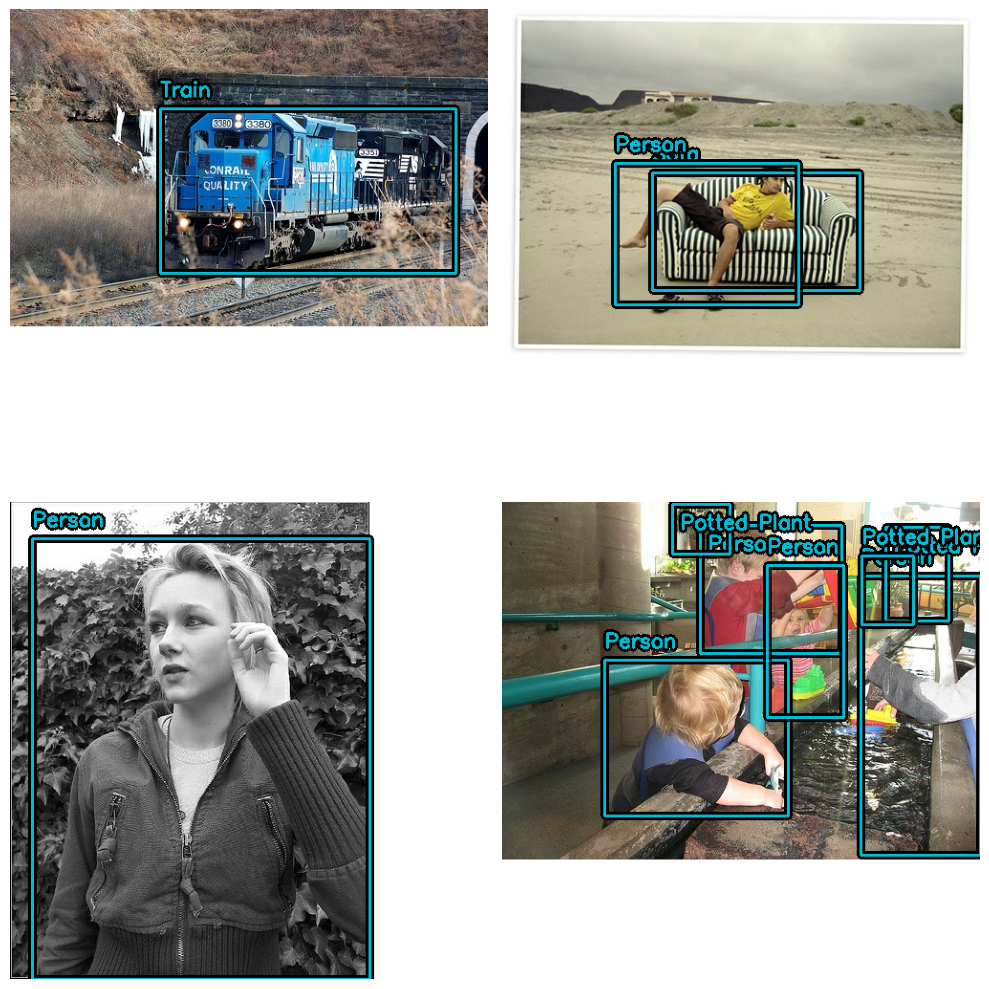

In [ ]:
visualize_dataset(
    train_ds, bounding_box_format="xywh", value_range=(0, 255), rows=2, cols=2
)

Viewing some images of the evaluation dataset, to verify their correctness

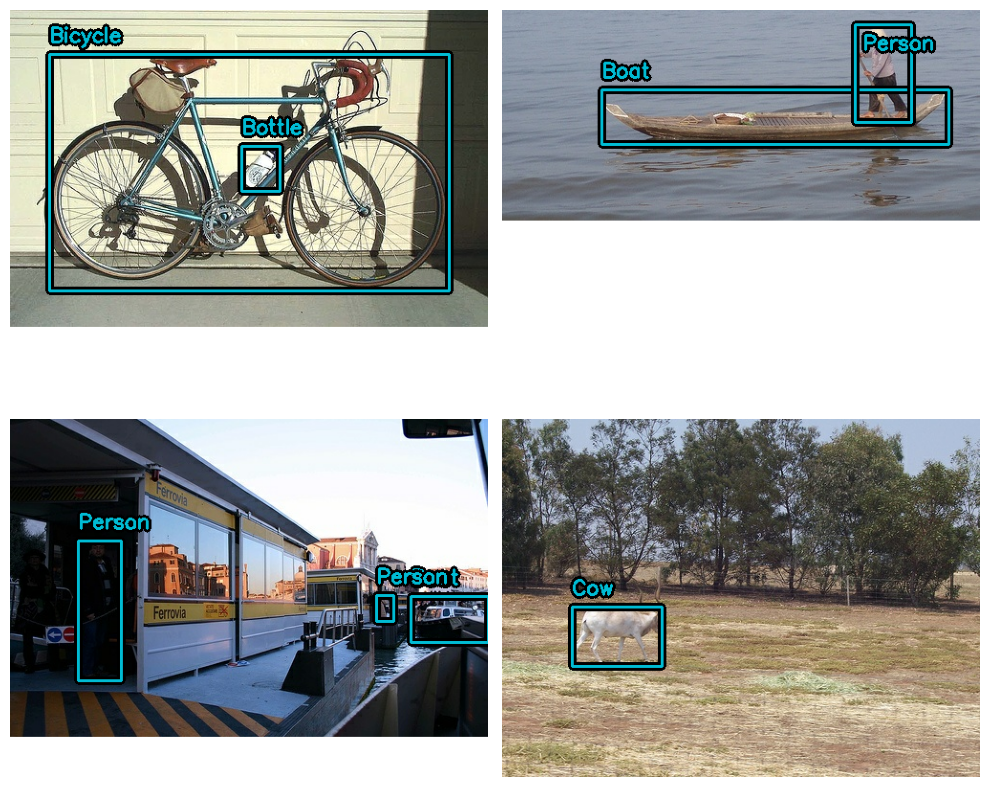

In [ ]:
visualize_dataset(
    eval_ds,
    bounding_box_format="xywh",
    value_range=(0, 255),
    rows=2,
    cols=2,
    # If you are not running your experiment on a local machine, you can also
    # make `visualize_dataset()` dump the plot to a file using `path`:
    # path="eval.png"
)

## Data Augmentation


In this section, data augmentation techniques will be used to expand the working dataset. It is important to keep the bounding boxes centered on the correct subjects even if the images are subjected to various distortions, as we see in the printed examples

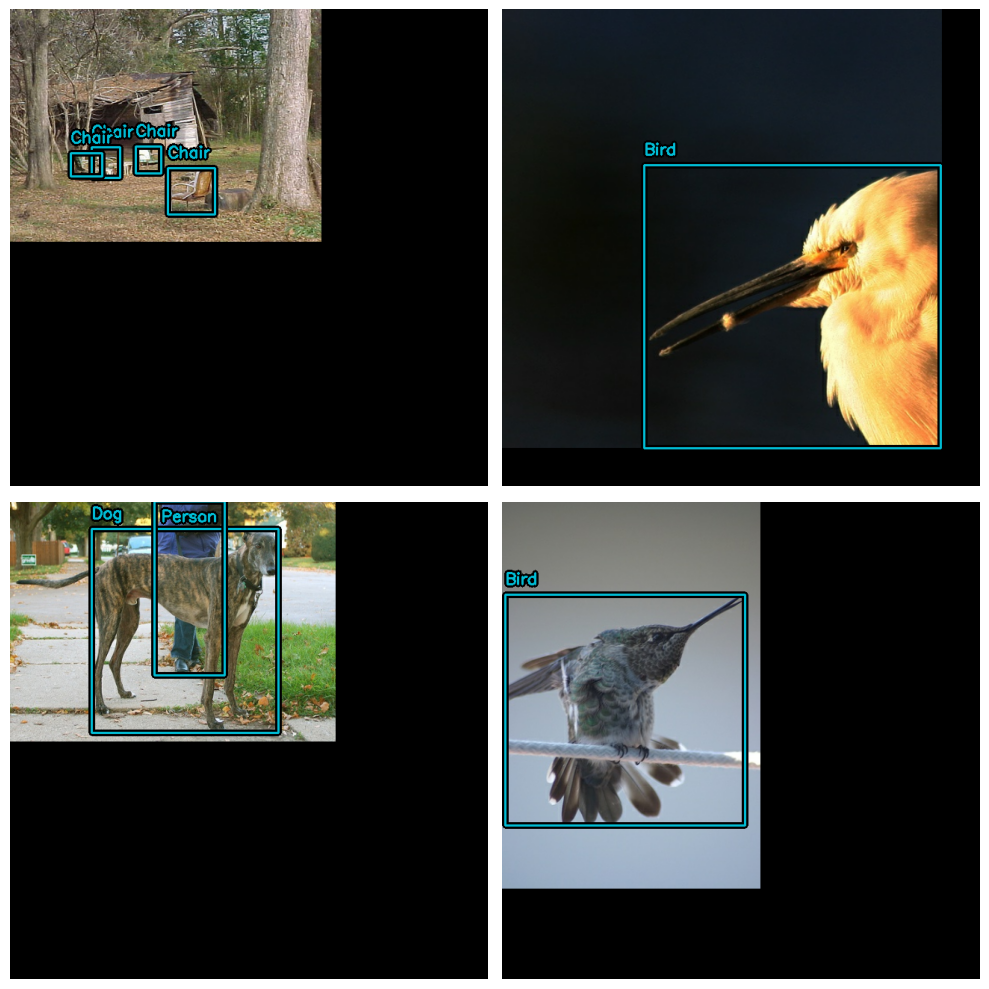

In [ ]:
augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xywh"),
        keras_cv.layers.JitteredResize(
            target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format="xywh"
        ),
    ]
)

train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)
visualize_dataset(
    train_ds, bounding_box_format="xywh", value_range=(0, 255), rows=2, cols=2
)

In [ ]:
inference_resizing = keras_cv.layers.Resizing(
    640, 640, bounding_box_format="xywh", pad_to_aspect_ratio=True
)
eval_ds = eval_ds.map(inference_resizing, num_parallel_calls=tf.data.AUTOTUNE)

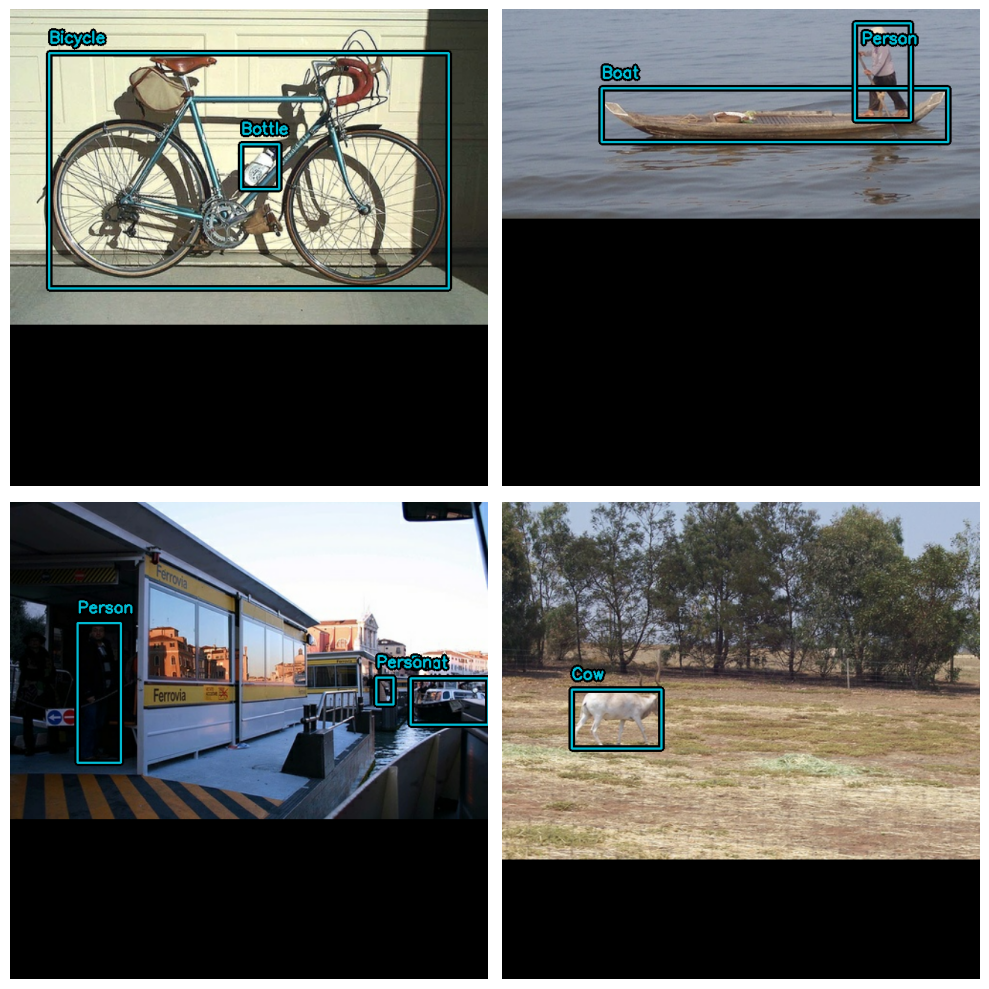

In [ ]:
visualize_dataset(
    eval_ds, bounding_box_format="xywh", value_range=(0, 255), rows=2, cols=2
)

In order to be TPU compatible, bounding box Tensors need to be Dense instead of Ragged

In [ ]:

def dict_to_tuple(inputs):
    return inputs["images"], bounding_box.to_dense(
        inputs["bounding_boxes"], max_boxes=32
    )


train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
eval_ds = eval_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
eval_ds = eval_ds.prefetch(tf.data.AUTOTUNE)

## Optimizer

We define the starting learning rate which will then be reduced during the process

In [ ]:
base_lr = 0.005
# including a global_clipnorm is extremely important in object detection tasks
optimizer = tf.keras.optimizers.SGD(
    learning_rate=base_lr, momentum=0.9, global_clipnorm=10.0
)

## Metrics Evaluation

We will use the COCO metrics, the most widespread, to verify the quality of the training

In [ ]:
coco_metrics = keras_cv.metrics.BoxCOCOMetrics(
    bounding_box_format="xywh", evaluate_freq=20
)

Definition of the function to print these metrics

In [ ]:

def print_metrics(metrics):
    maxlen = max([len(key) for key in result.keys()])
    print("Metrics:")
    print("-" * (maxlen + 1))
    for k, v in metrics.items():
        print(f"{k.ljust(maxlen+1)}: {v.numpy():0.2f}")

We use a custom callback to ensure model compatibility with TPU

In [ ]:
class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
    def __init__(self, data):
        super().__init__()
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(
            bounding_box_format="xywh",
            # passing 1e9 ensures we never evaluate until
            # `metrics.result(force=True)` is
            # called.
            evaluate_freq=1e9,
        )

    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        for batch in tqdm.tqdm(self.data):
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            self.metrics.update_state(y_true, y_pred)

        metrics = self.metrics.result(force=True)
        logs.update(metrics)
        return logs

## Model Creation

We use the pre-trained ResNet50 backbone, from the KerasCV API to construct an untrained RetinaNet Model

In [ ]:
model = keras_cv.models.RetinaNet.from_preset(
    "resnet50_imagenet",
    num_classes=len(class_mapping),
    # For more info on supported bounding box formats, visit
    # https://keras.io/api/keras_cv/bounding_box/
    bounding_box_format="xywh",
)

## Training

To train our model we use the two functions compile() and fit()

Loss Functions

"Focal" and "smoothl1" will be used as loss functions, this is because the first allows us to emphasize more the examples that are carried out with greater difficulty, while the second is used to prevent the learning rate from "exploding"

In [ ]:
model.compile(
    classification_loss="focal",
    box_loss="smoothl1",
    optimizer=optimizer,
    # We will use our custom callback to evaluate COCO metrics
    metrics=None,
)

In [ ]:
model.fit(
    train_ds,
    validation_data=eval_ds,
    # Run for 10-35~ epochs to achieve good scores.
    epochs=20,
    callbacks=[EvaluateCOCOMetricsCallback(eval_ds)],
)

Epoch 1/20
200/200 [==============================] - ETA: 0s - loss: 1.2289 - box_loss: 0.5337 - classification_loss: 0.6952 - percent_boxes_matched_with_anchor: 0.9084

  1%|▏         | 17/1238 [02:17<2:44:21,  8.08s/it]


KeyboardInterrupt: ignored

## Model Download

Let's create a folder where we can save the newly trained model

In [ ]:
!mkdir -p saved_model
keras.models.save_model(model,'saved_model/my_model', save_format='tf')

We transform our model into a frozen_graph to be able to use it with OpenCV, using the convert_to_constants() function

In [ ]:
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

#path of the directory where you want to save your model
frozen_out_path = ''

# name of the .pb file
frozen_graph_filename = 'frozen_graph'

#loaded_model = tf.saved_model.load('saved_model/my_model')

# Convert Keras model to ConcreteFunction
full_model = tf.function(lambda x: model(x))
full_model = full_model.get_concrete_function(tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype))

# Get frozen ConcreteFunction
frozen_func = convert_variables_to_constants_v2(full_model)
frozen_func.graph.as_graph_def()
layers = [op.name for op in frozen_func.graph.get_operations()]

# To print information about the model
#print("-" * 60)
#print("Frozen model layers: ")
#for layer in layers:
#    print(layer)
#print("-" * 60)
#print("Frozen model inputs: ")
#print(frozen_func.inputs)
#print("Frozen model outputs: ")
#print(frozen_func.outputs)
# Save frozen graph to disk

tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
                  logdir=frozen_out_path,
                  name=f"{frozen_graph_filename}.pb",
                  as_text=False)
# Save its text representation
tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
                  logdir=frozen_out_path,
                  name=f"{frozen_graph_filename}.pbtxt",
                  as_text=True)

'frozen_graph.pbtxt'

## Plotting Results

We construct a dataset with larger batches

In [ ]:
visualization_ds = eval_ds.unbatch()
visualization_ds = visualization_ds.ragged_batch(16)
visualization_ds = visualization_ds.shuffle(8)

We create a function to plot our inferences

In [ ]:
def visualize_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images)
    y_pred = bounding_box.to_ragged(y_pred)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=2,
        cols=4,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )

Finally we can visualize our model predictions

1/1 [==============================] - 13s 13s/step


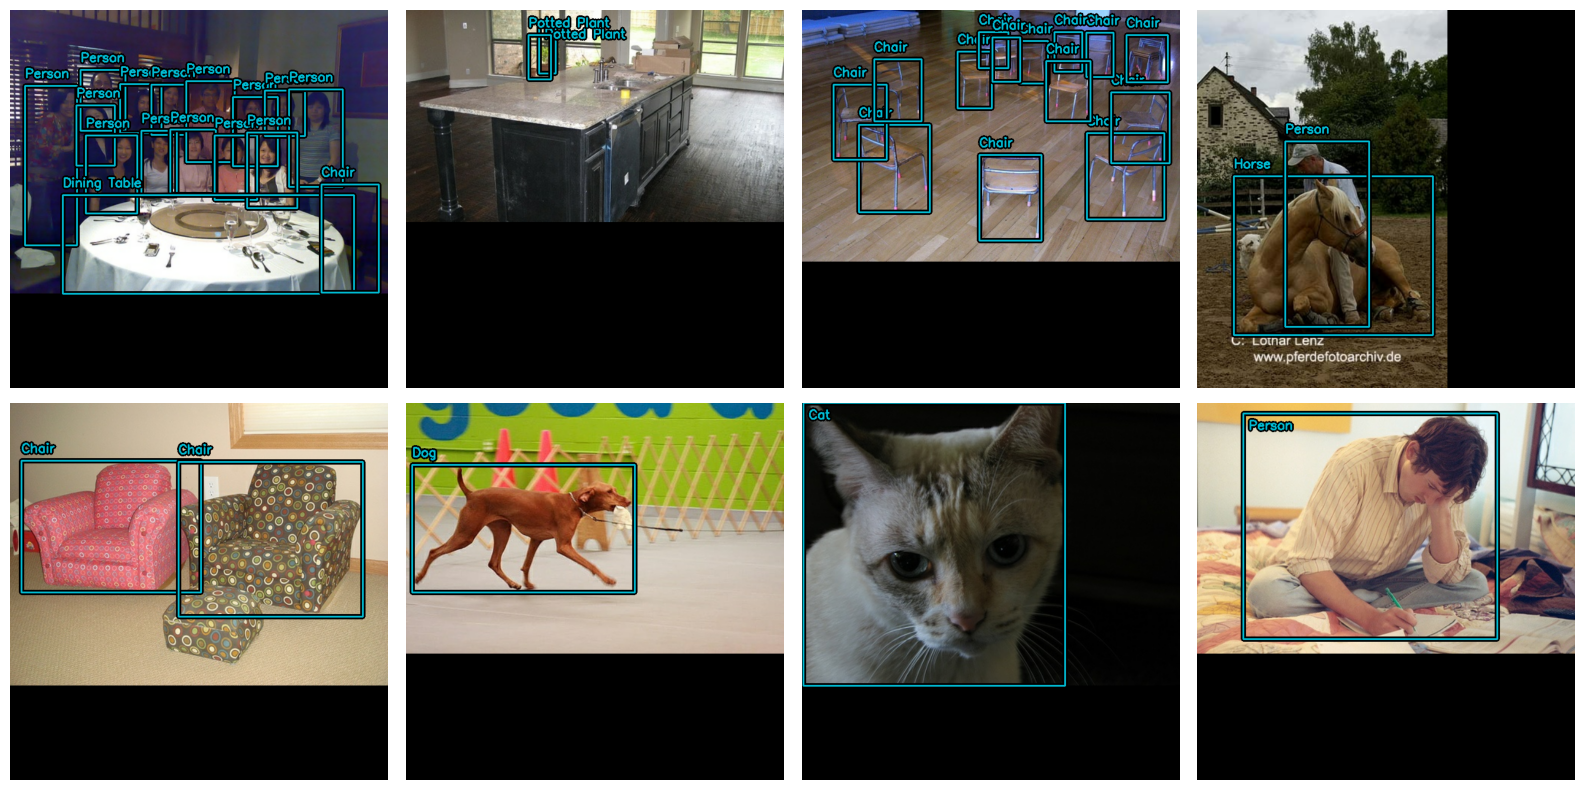

In [ ]:
model.prediction_decoder = keras_cv.layers.MultiClassNonMaxSuppression(
    bounding_box_format="xywh",
    from_logits=True,
    iou_threshold=0.5,
    confidence_threshold=0.75,
)

visualize_detections(model, dataset=visualization_ds, bounding_box_format="xywh")